# Lecture 19: EM algorithm and alternating minimization

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture19.ipynb)

In this lecture, we'll look at the well known EM algorithm and alternating minimization for solving non-convex optimization problems.

Overview:

* [Alternating minimization](#am)
* [EM](#em)

Bibliographic notes: 

In [1]:
%matplotlib inline

#import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1)

from optimizers import gradient_descent
from projections import nuclear_projection
from plotters import convergence_plot, kwargs, setup_layout
setup_layout()

<a name="am"></a>

## Low-rank matrix factorization

In low-rank matrix factorization we're generally trying to solve an objective of the form

$$
\min_{\mathrm{rank}(M)\le k} f(M),
$$

where $f\colon\mathbb{R}^{m\times n}\to\mathbb{R}$ is a convex function. Note that the set of rank $k$ matrices forms a non-convex set.

In lecture 5, we saw that this problem can be attacked using the *nuclear norm relaxation* of the rank constraint. Projecting onto the unit ball of the nuclear norm was a costly operation that does not scale large matrices. We saw how to mitigate this problem using the Frank-Wolfe algorithm, in which the nuclear norm projection is replaced by a linear optimization step that is solved by the power method.

Here we'll see a natural approach to solve the non-convex formulation directly without any relaxation via *alternating minimization*.

### Alternating minimization

The idea behind alternating minimization is that a rank $k$ matrix $M$ can be written in factored form as $M=XY^\top,$ where $X\in\mathbb{R}^{m\times k}$ and $Y\in\mathbb{R}^{n\times k}$.

Given initial guesses $X_0,Y_0,$ we can then alternate between optimizing $X$ and optimizing $Y$ separately as follows:

For $t=1,\dots, T:$
* $X_t=\arg\min_{X} f(XY_{t-1}^\top)$
* $Y_t=\arg\min_{Y} f(X_t Y^\top)$

Since matrix multiplication is bilinear, the function $f(XY^\top)$ is convex in its argument $X$ and also convex in its argument $Y$.

In [2]:
def alternating_minimization(left, right, update_left, update_right,
                            num_updates):
    """Alternating minimization."""
    iterates = [(left, right)]
    for _ in range(num_updates):
        left = update_left(right)
        right = update_right(left)
        iterates.append((left, right))
    return iterates

Check out [this monograph](https://arxiv.org/abs/1712.07897) by Jain and Kar for a survey of convergence results for alternating minimization.

### Matrix completion

A common instance of this general problem is known as *matrix completion*. Here we have a partially observed matrix $m\times n$ matrix and we try to fill in its missing entries. This is generally impossible unless we make additional assumptions on the target matrix. A natural assumption is that the target matrix is close to low rank. In other words, the matrix is specified by far fewer than $mn$ parameters.

To set up some notation:
* We observe coordinates of an unknown matrix $A\in\mathbb{R}^{m\times n}$ specified by a set $\Omega.$
* We denote by $P_\Omega$ the coordinate projection of a matrix onto the set of entries in $\Omega.$
* We will denote by $\|\cdot\|_F$ the Frobenius norm.

The matrix completion objective can then be written as:

$$
\min_{X\in\mathbb{R}^{m\times k}, Y\in\mathbb{R}^{n\times k}}
\frac12\|P_{\Omega}(A-XY^\top)\|_F^2
$$

### Assumptions

To make the problem tractable, researchers rely on primarily two assumptions:

* Uniformly random samples: The entries of $\Omega$ are chosen independently at random.
* Incoherence: The entries of $A$ are "spread out" so that a random samples picks up a propertional share of $A$ with good probability. Formally, this can be achieved by assuming that the singular vectors of $A$ have small $\ell_\infty$-norm.

### Alternating updates for matrix completion

Here we'll compute the updates needed for alternating minimization via a naive direct solve in each row using the pseudoinverse. (**This approach is pretty slow!**) We could instead use any of the convex solvers we already saw. The advantage of a direct solve is that we have no additional hyperparameters to worry about.

[TODO: Fast version of direct solve]

In [3]:
def update_right(A, S, X):
    """Update right factor for matrix completion objective."""
    m, n = A.shape
    _, k = X.shape
    Y = np.zeros((n, k))
    # For each row, solve a k-dimensional regression problem
    for i in range(n):
        d = np.zeros(m)
        d[S[:, i] == True]=1
        P = np.diag(d)
        PX = np.dot(P, X)
        B = np.dot(X.T, PX)
        c = np.dot(A[:, i], PX)
        Y[i,:] = np.dot(np.linalg.pinv(B), c).transpose()
    return Y

def update_left(A, S, Y):
    return update_right(A.T, S.T, Y)

We can now instantiate the general algorithm for our problem.

In [4]:
def altmin(A, S, rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.random.normal(0, 1, (m, rank))
    Y = np.random.normal(0, 1, (n, rank))
    return alternating_minimization(X, Y, 
                                    lambda Y: update_left(A, S, Y), 
                                    lambda X: update_right(A, S, X),
                                    num_updates)

Below is code to plot a matrix decomposition in a neat manner. Ignore this for now, unless you're really into matplotlib.

In [5]:
def plot_decomposition(A, U=None, V=None):
    """Plot matrix decomposition."""
    m, n = A.shape
    fig_height = 9
    fig_width = float(n)*fig_height/m
    
    cmap=plt.get_cmap('bwr')
    bounds=np.concatenate([np.linspace(-100,-4,1), np.linspace(-4,-0.005,114),
        np.linspace(-0.005,0.005,25), np.linspace(0.005,4,114),np.linspace(4,100,1)])
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(fig_width, fig_height))
    
    rects = [[0.05,0.15,0.8,0.8],[0.825,0.15,0.1,0.8],[0.05,0.05,0.8,0.1]]
    
    for (rect, mat) in zip(rects, [A, U, V]):
        if type(mat)==type(None):
            break
        ax = fig.add_axes(rect)
        ax.imshow(mat, cmap=cmap,norm=norm,interpolation='none')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.xaxis.set_tick_params(size=0)    
        ax.yaxis.set_tick_params(size=0)

    plt.show()

Let's see how alternating minimization works in a toy example.

In [6]:
def subsample(A, density):
    """Randomly zero out entries of the input matrix."""
    C = np.matrix.copy(A)
    B = np.random.uniform(0, 1, C.shape)
    C[B > density] = 0
    return C, B <= density    
    
def example1():
    """Run alternating minimization on subsample of rank 2 matrix."""

    A = np.zeros((40, 70))
    # Create rank 2 matrix with checkerboard pattern
    for i in range(0,40):
        for j in range(0,70):
            if divmod(i, 2)[1]==0:
                A[i,j] += -3.0
            if divmod(i, 2)[1]==1:
                A[i,j] += 3.0
            if divmod(j, 2)[1]==0:
                A[i,j] += 1.0
            if divmod(j, 2)[1]==1:
                A[i,j] += -1.0
    plot_decomposition(A)
    B, S = subsample(A, 0.25)
    plot_decomposition(B)
    results = altmin(A, S, 2, 10)
    for (U, V) in results:
        plot_decomposition(np.dot(U, V.T), U, V.T)        
    
    return

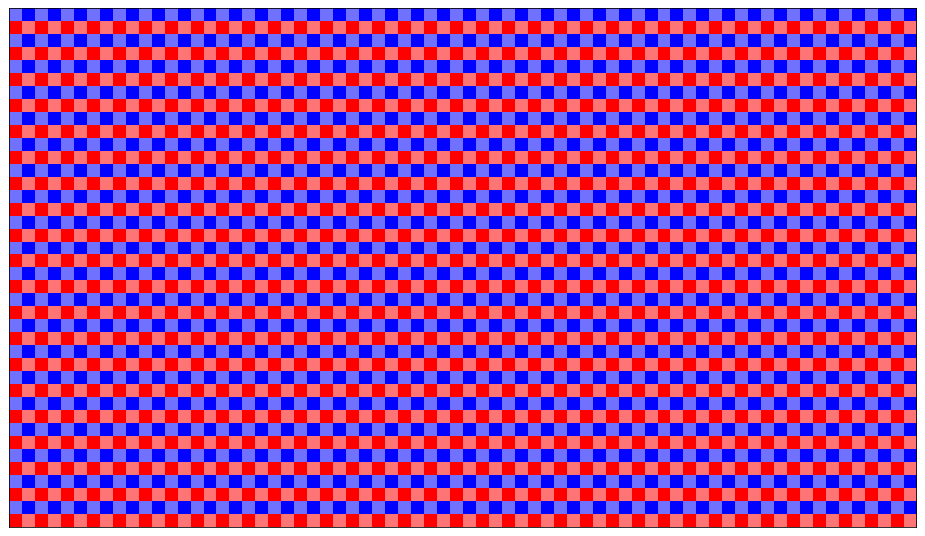

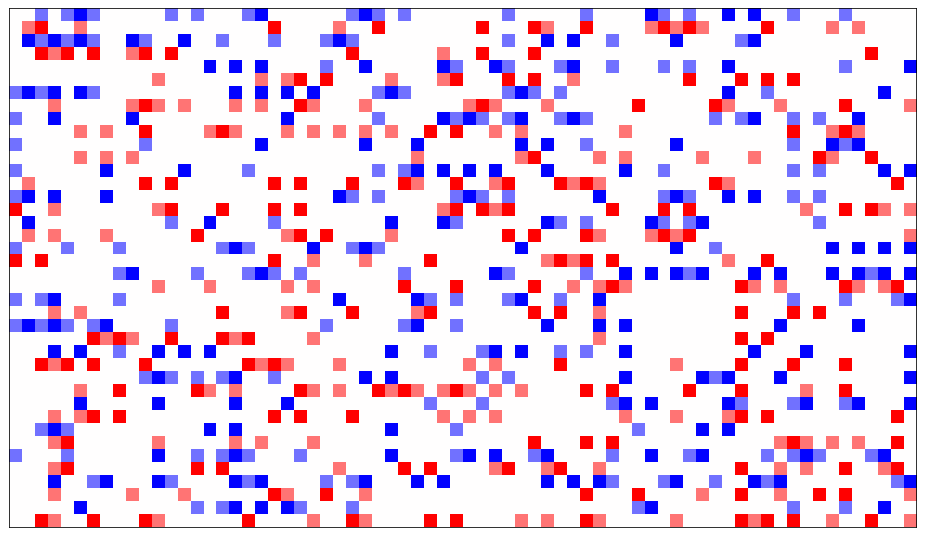

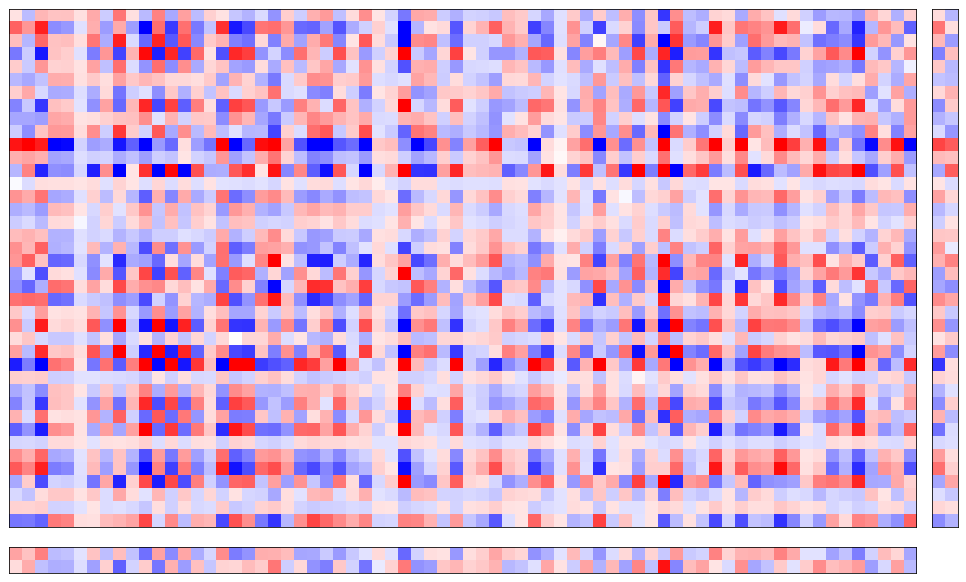

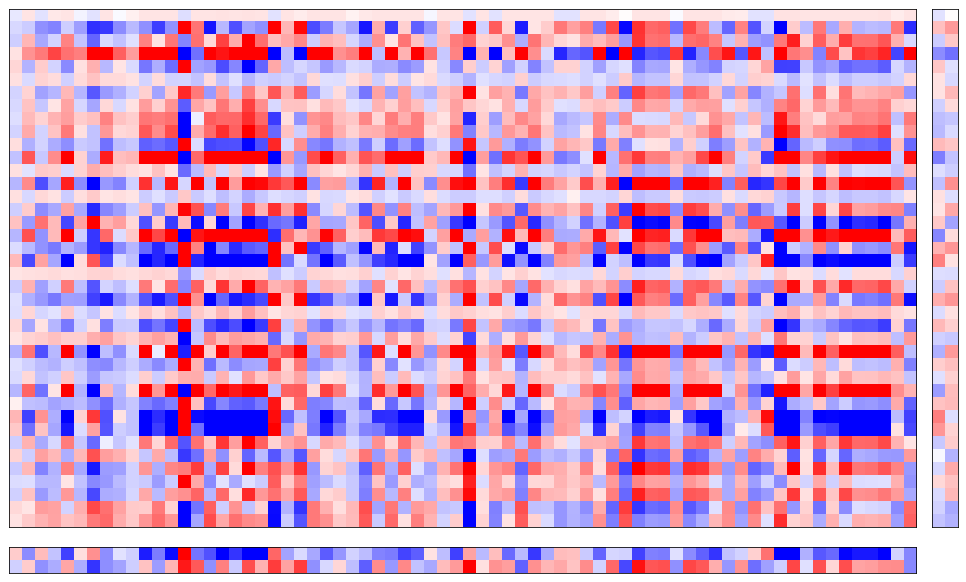

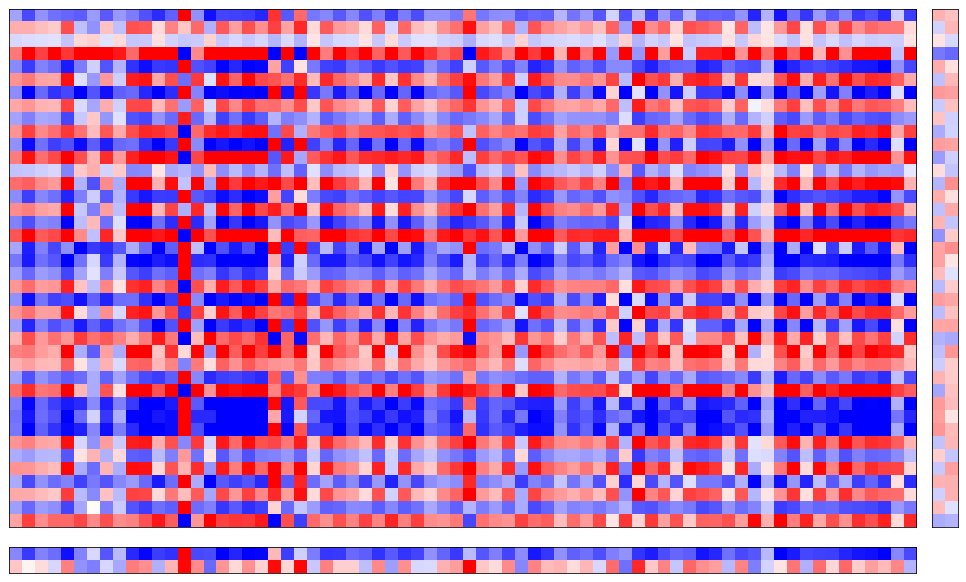

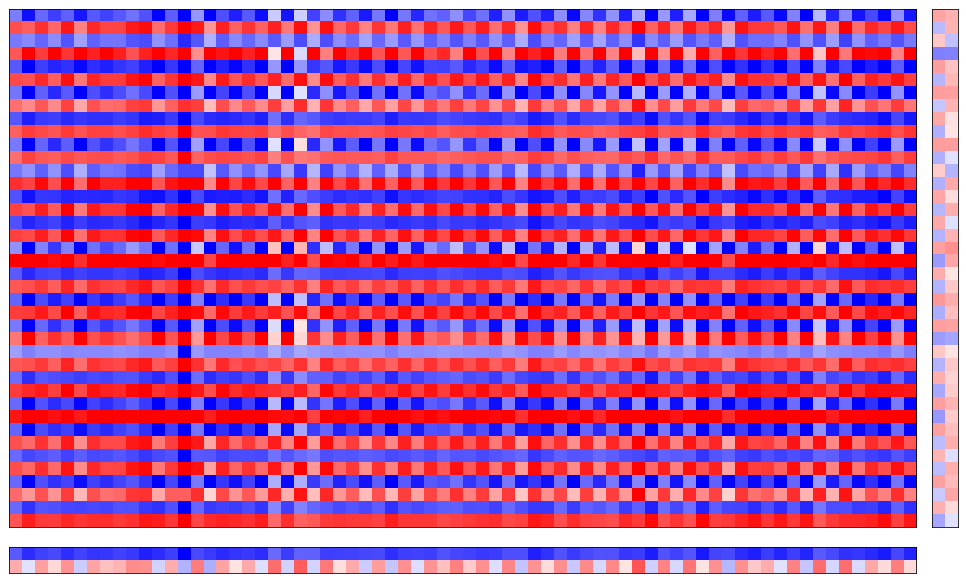

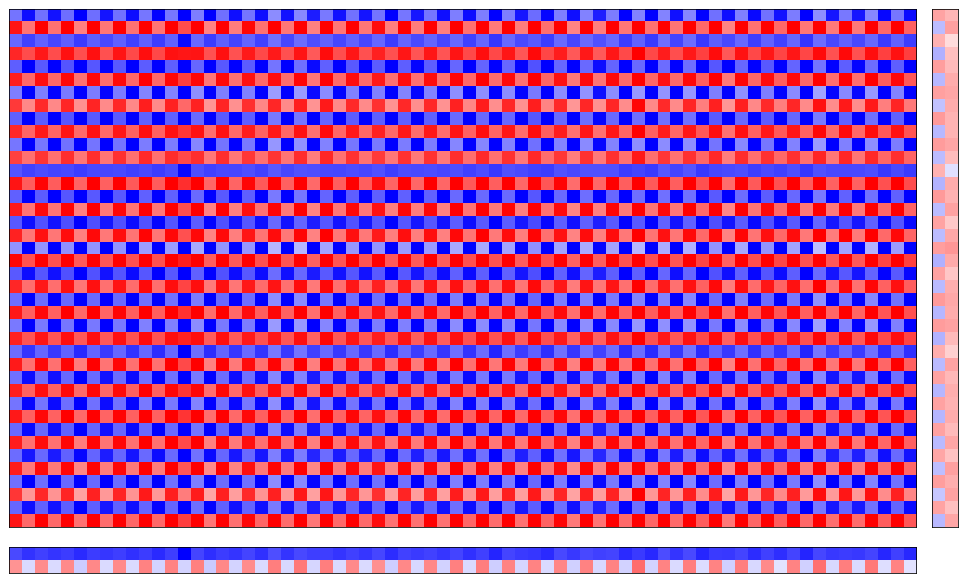

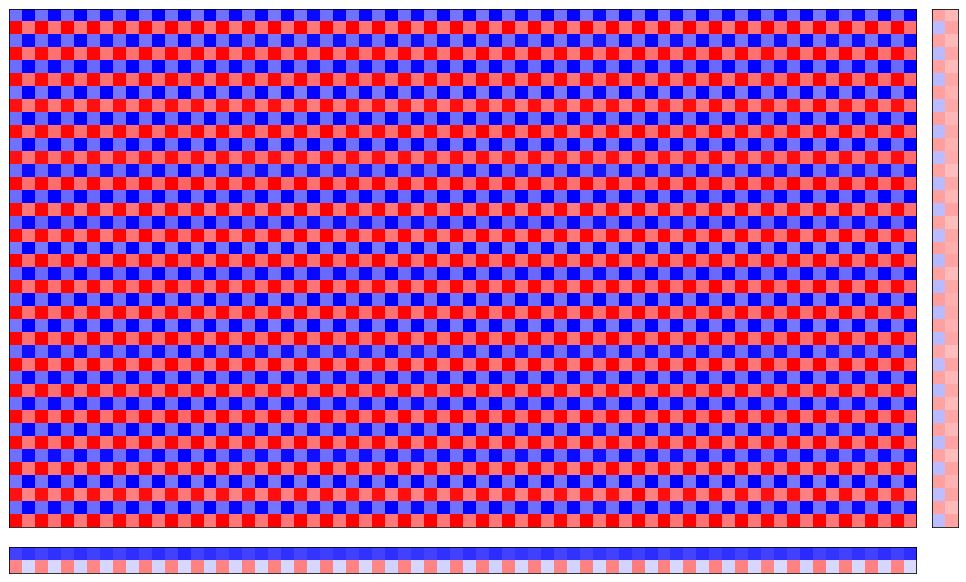

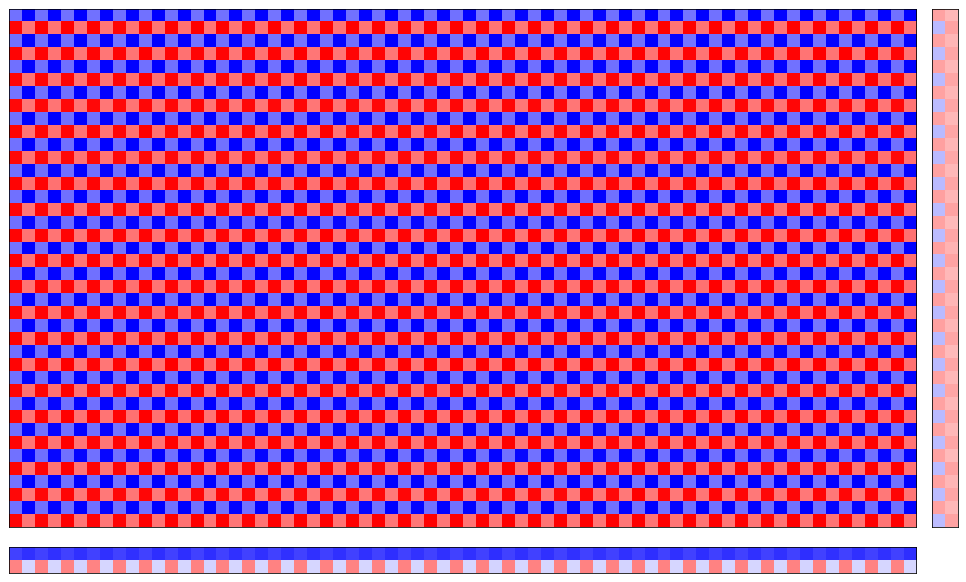

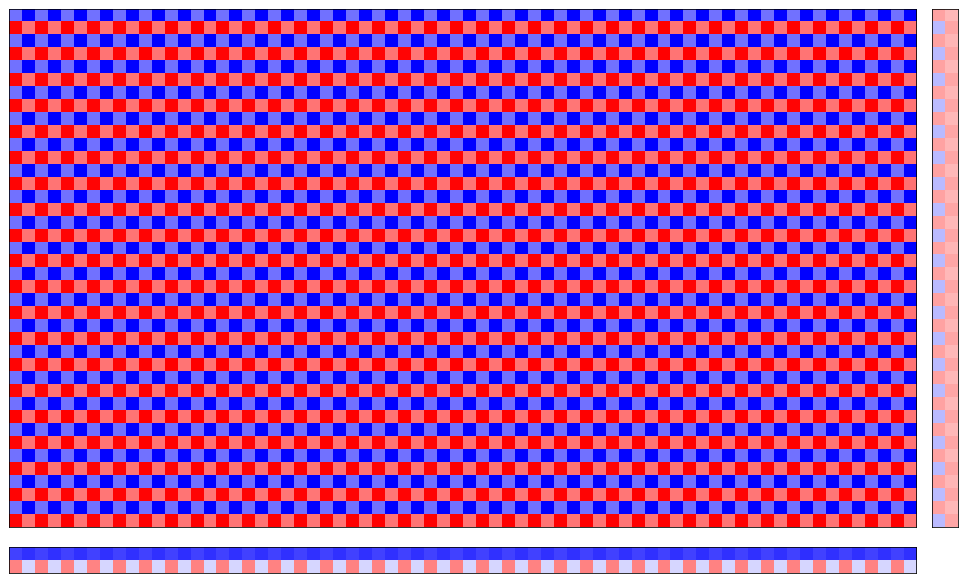

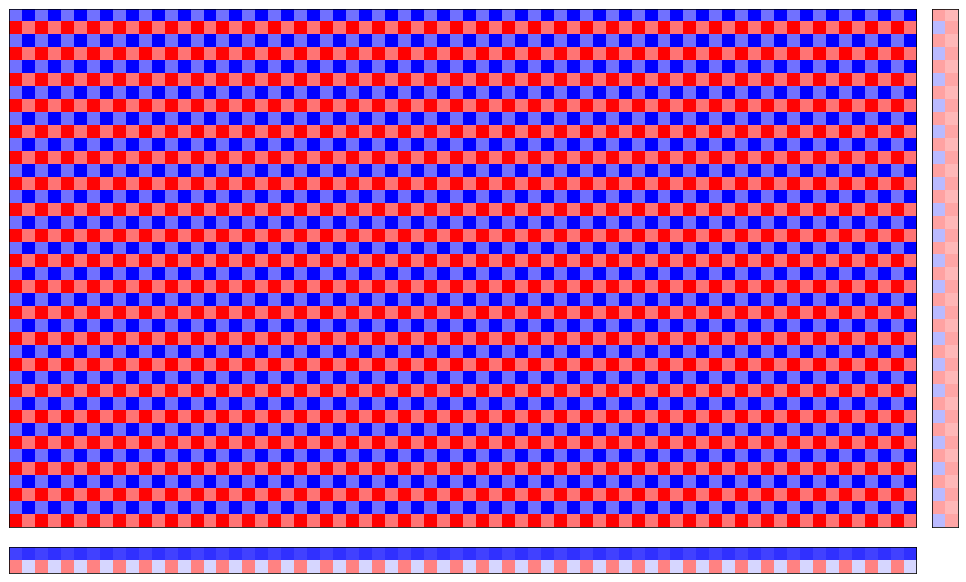

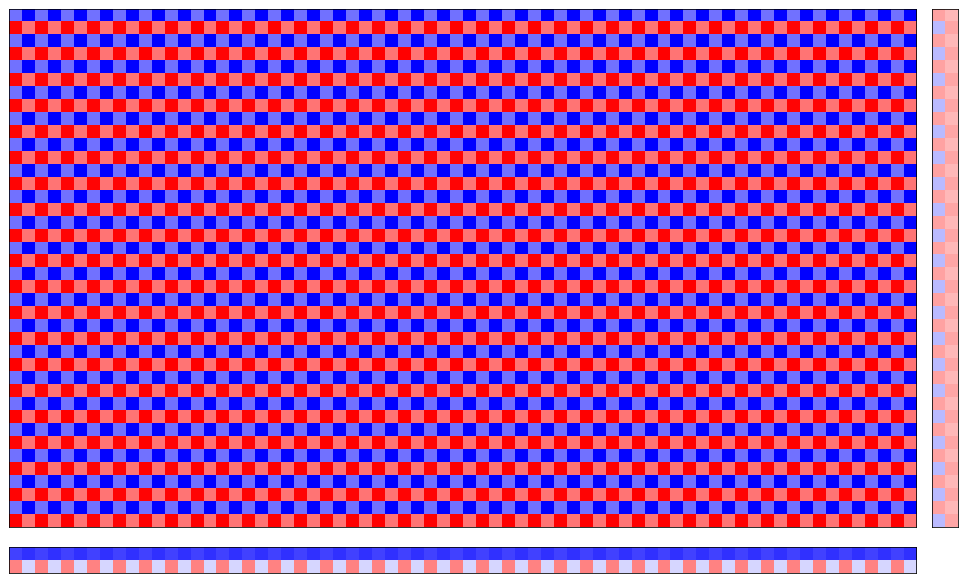

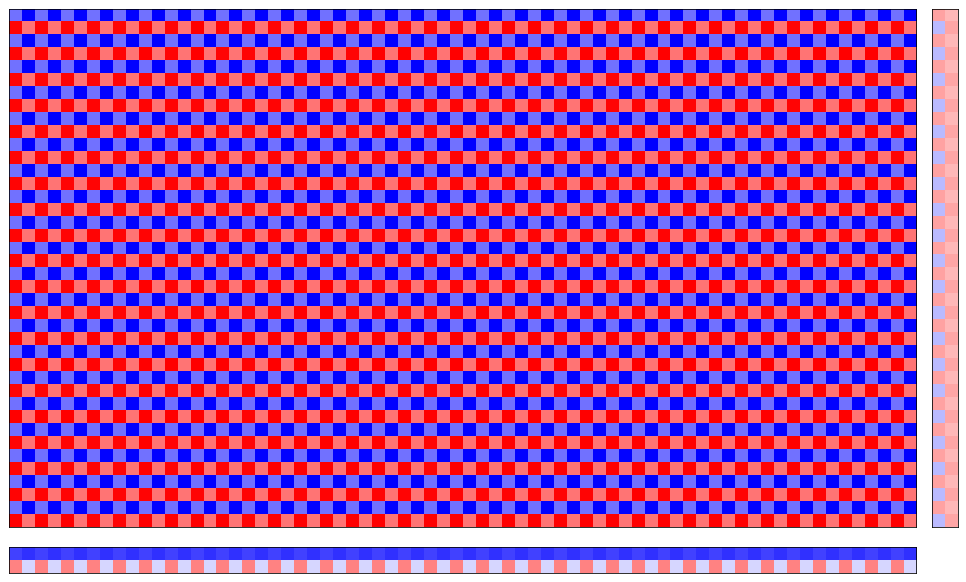

In [7]:
# TODO color legend
example1()

We see that after a few iterations, alternating minimization has found a good approximation. Restart this algorithm a few times to see that the convergence is affected strongly by the random initialization.

## Exercises

* Code up a more serious implementation that does not ever compute a full $m\times n$ matrix, but rather works with a given set of observed entries. Use stochastic gradient descent as a sub-routine for the updates.
* Do a running time analysis of the algorithm.

## Comparison with gradient descent and nuclear norm projection

Below is our example from Lecture 5.

In [8]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
L = np.diag(np.random.uniform(0, 1, k))
L /= np.sum(L)
A = U.dot(L.dot(U.T))
# pick which entries we observe uniformly at random
S = np.random.randint(0, 2, (n, n))
# multiply A by S coordinate-wise
# B = P_\Omega(A)
B = np.multiply(A, S)

def mc_objective(B, S, X):
    """Matrix completion objective."""
    # 0.5*\|P_\Omega(A-X)\|_F^2
    return 0.5 * np.linalg.norm(B-np.multiply(X, S), 'fro')**2

def mc_gradient(B, S, X):
    """Gradient of matrix completion objective."""
    return np.multiply(X, S) - B


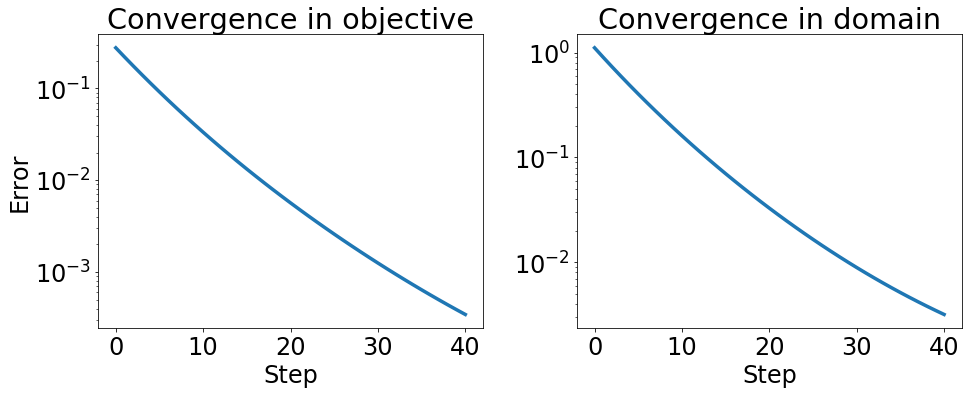

In [9]:
def example2():
    # start from random matrix of nuclear norm 1
    X0 = np.random.normal(0,1, (n,n))
    X0 = nuclear_projection(X0.dot(X0.T))
    objective = lambda X: mc_objective(B, S, X)
    gradient = lambda X: mc_gradient(B, S, X)
    Xs = gradient_descent(X0, [0.2]*40, gradient, nuclear_projection)

    convergence_plot([objective(X) for X in Xs],
                    [np.linalg.norm(A-X, 'fro')**2 for X in Xs])
    
example2()

The algorithm was pretty slow even on this tiny example.

Below we compare it with a variant of alternating minimization that makes a single gradient step in each update. There are numerous natural variants depending on which optimizer we choose. A popular method involves stochastic updates that use only a single entry.

In [10]:
def mc_objective_factored(B, S, X, Y):
    """Matrix completion objective."""
    m, n = B.shape
    return 0.5 * np.linalg.norm(B-np.multiply(np.dot(X, Y.T), S), 'fro')**2

def altmin_gd(rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.linalg.qr(np.random.normal(0, 1, (n, k)))[0]
    Y = np.linalg.qr(np.random.normal(0, 1, (n, k)))[0]
    iterates = [(X, Y)]
    for i in range(num_updates):
        X = X - grad(lambda X: mc_objective_factored(B, S, X, Y))(X)
        Y = Y - grad(lambda Y: mc_objective_factored(B, S, X, Y))(Y)
        iterates.append((X, Y))
    return iterates

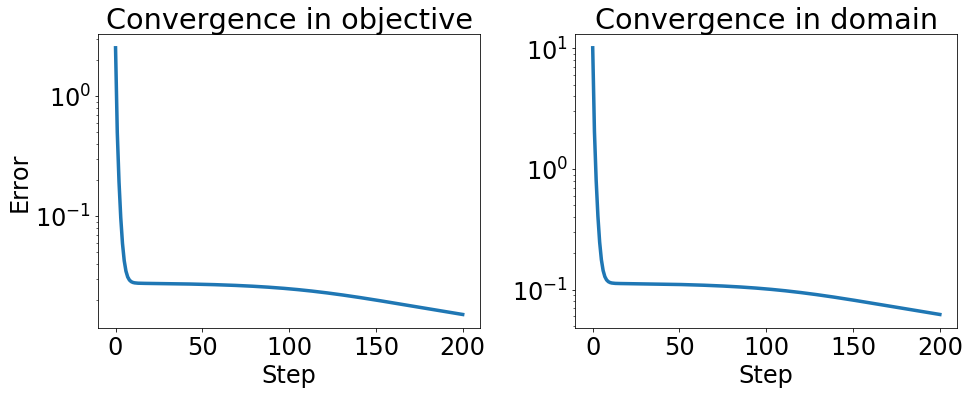

In [11]:
results = altmin_gd(10, 200)
obj_values = [mc_objective_factored(B, S, X, Y) for (X, Y) in results]
dom_values = [np.linalg.norm(A-X.dot(Y.T), 'fro')**2 for (X, Y) in results]
convergence_plot(obj_values, dom_values)

The convergence behavior is pretty peculiar. It rapidly converges to the quality of the all zeros solution and then slows down substantially. We saw something similar happen to Frank-Wolfe.

In [12]:
mc_objective(B, S, 0)

0.028210546968991789

<a name="em"></a>

## EM

TODO: Explain EM

### Mixtures of Gaussians

TODO: Finish mixture of two gaussians example

In [13]:
def gaussian_density(mu, sigma, x):
    """Unnormalized gaussian density."""
    return np.exp(-0.5*(mu-x)**2/1**2)

def gaussian_likelihood(parameters, latent, data):
    """Likelihood of gaussian mixture model."""
    mu1, sigma1, mu2, sigma2 = parameters
    vals1 = gaussian_density(mu1, sigma1, data)
    vals2 = gaussian_density(mu2, sigma2, data)
    return np.dot(vals1, latent) + np.dot(vals2, 1.0-latent)

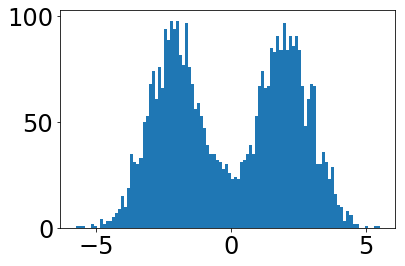

In [14]:
data = np.hstack([np.random.normal(-2, 1, 2000),
                  np.random.normal(2, 1, 2000)])
_ = plt.hist(data, bins=100)


In [15]:
init_param = np.array([0., 1., 1., 1.])
init_latent = np.random.uniform(0, 1, len(data))

In [17]:
#results = em(gaussian_likelihood, init_param, init_latent, data, 10, lambda x: np.clip(x, 0, 1))
#print results[-1][0]

<a name="kmeans"></a>

## k-means




Example courtesy of Jake Vanderplas:

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [ ]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

## That's it. Thanks.